# Arima Time Series Model

#### Library Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pmdarima.arima import auto_arima
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")

In [2]:
#pip show statsmodels

#### Bring dataframes from ForecastingStockVolatility.ipynb

In [3]:
nike_df =  pd.read_pickle('data/nike_prep4.pkl')

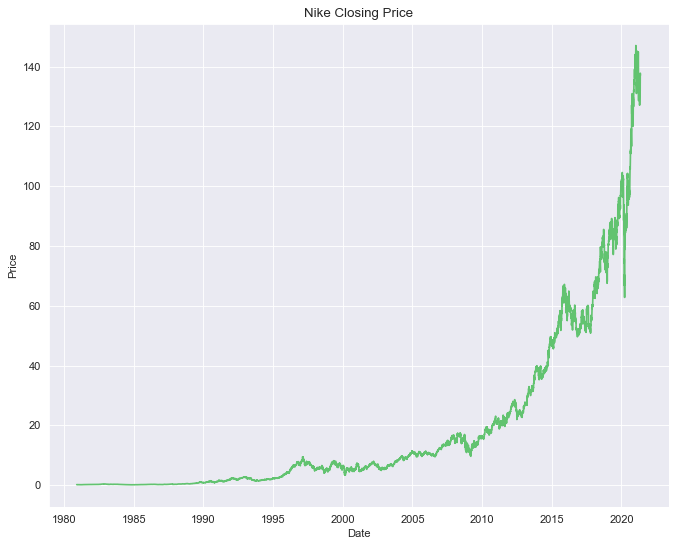

In [53]:
figure(figsize=(10, 8), dpi=80)
nike_df.index=nike_df['date']
sns.set_style("darkgrid")
sns.lineplot(x=nike_df.index,y=nike_df.close,data=nike_df)
sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot

plt.title('Nike Closing Price')
plt.xlabel('Date')
plt.ylabel('Price');

#### Indexed Nike dataframe

In [6]:
nike_df.head()

,date,open,high,low,close,adj_close,volume,year,month,day,week_of_year,day_of_week,day_of_week_number,close_open_variation,intraday_variation,daily_change,moving_average_10,moving_average_15,moving_average_50
date,,,,,,,,,,,,,,,,,,,
1980-12-02,1980-12-02,0.179688,0.183594,0.179688,0.179688,0.132428,100710400,1980,12,2,49,Tuesday,2,0.000000,2.173768,0.000000,0.179688,0.179688,0.179688
1980-12-03,1980-12-03,0.177734,0.177734,0.175781,0.175781,0.129549,25177600,1980,12,3,49,Wednesday,3,-1.098833,1.111042,-0.021743,0.177735,0.177735,0.177735
1980-12-04,1980-12-04,0.181641,0.183594,0.181641,0.181641,0.133868,22694400,1980,12,4,49,Thursday,4,0.000000,1.075198,0.033337,0.179037,0.179037,0.179037
1980-12-05,1980-12-05,0.175781,0.175781,0.171875,0.171875,0.126670,7590400,1980,12,5,49,Friday,5,-2.222083,2.272582,-0.053765,0.177246,0.177246,0.177246
1980-12-08,1980-12-08,0.164063,0.164063,0.162109,0.162109,0.119473,5414400,1980,12,8,50,Monday,1,-1.191006,1.205362,-0.056820,0.174219,0.174219,0.174219


#### Plot the Rolling Mean and Standard Deviation of the Opening price variable to determine if time series is Stationary

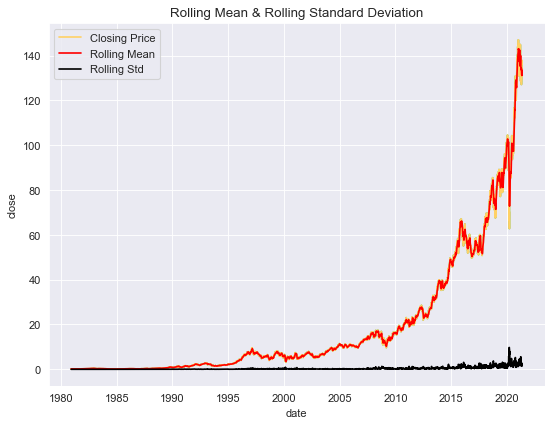

In [7]:
rolling_mean = nike_df['close'].rolling(window = 12,min_periods = 1).mean()
rolling_std = nike_df['close'].rolling(window = 12,min_periods = 1).std()

figure(figsize=(8, 6), dpi=80)

# Change default palette
sns.lineplot(x=nike_df.index,y=nike_df.close,data=nike_df)
sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot


plt.title('Rolling Mean & Rolling Standard Deviation of Apple Opening Stock Price')
plt.plot(nike_df.close, label = "Closing Price")

plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

#### From 'statsmodels' use the Augmented Dickey Fuller Test to determine stationarity 

In [8]:
result = adfuller(nike_df.close)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 4.040448571896713
p-value: 1.0
Critical Values:
	1%: -3.4309939847812645
	5%: -2.8618246034501813
	10%: -2.566921489274199


# Get Stationarity 

### First Difference

In [9]:
# Drop the first row of 'Close' column because It has 'NaN' value
first_order_diff = nike_df['close'].diff(1).dropna()

# Display the first five records
first_order_diff.head()

date
1980-12-03   -0.003907
1980-12-04    0.005860
1980-12-05   -0.009766
1980-12-08   -0.009766
1980-12-09   -0.003906
Name: close, dtype: float64

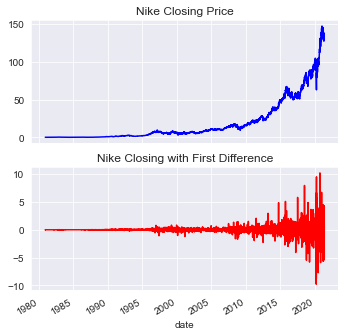

In [10]:
# Declare the fig abd ax as two arguments 
fig, ax = plt.subplots(2, sharex = True)
fig.set_size_inches(5.5, 5.5)
nike_df['close'].plot(ax = ax[0], color = 'b');
ax[0].set_title('Nike Closing Price')
first_order_diff.plot(ax = ax[1], color = 'r')
ax[1].set_title('Nike Closing with First Difference');

In [11]:
result = adfuller(nike_df.close)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 4.040448571896713
p-value: 1.0
Critical Values:
	1%: -3.4309939847812645
	5%: -2.8618246034501813
	10%: -2.566921489274199


### Function For Autocorrelation and Partial Autocorrelation plots


In [12]:
# plotds is method to plot time series, ACF and PACF
def plotds(xt, nlag = 30, fig_size = (12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags = 50, ax = ax_acf)
    plot_pacf(xt, lags = 50, ax = ax_pacf)
    plt.tight_layout()
    return None

### ACF and PACF plot for First Difference method

ADF Statistic: -15.257671
p-value: 0.000000


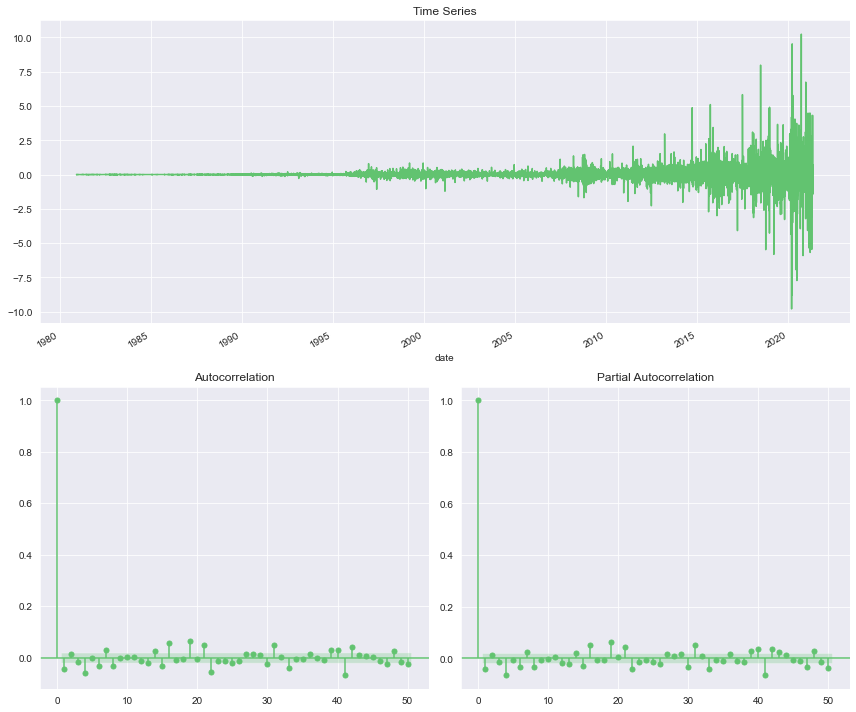

In [13]:
# plot the data with 50 lags
plotds(first_order_diff, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(first_order_diff)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

## Log10 Method

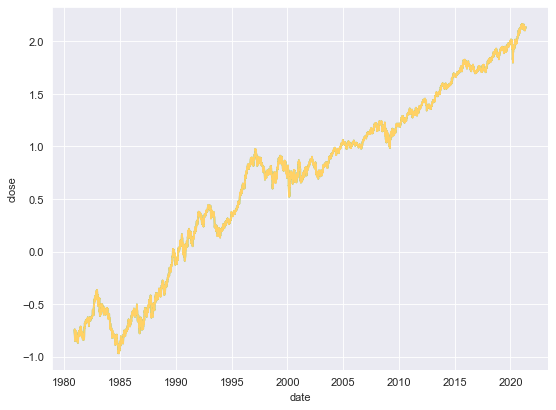

In [14]:
df_close_log = np.log10(nike_df.close)
figure(figsize=(8, 6), dpi=80)
sns.lineplot(x=df_close_log.index,y=df_close_log)
plt.plot(df_close_log);

### ACF and PACF plot for Logarithm method

ADF Statistic: -0.682266
p-value: 0.851290


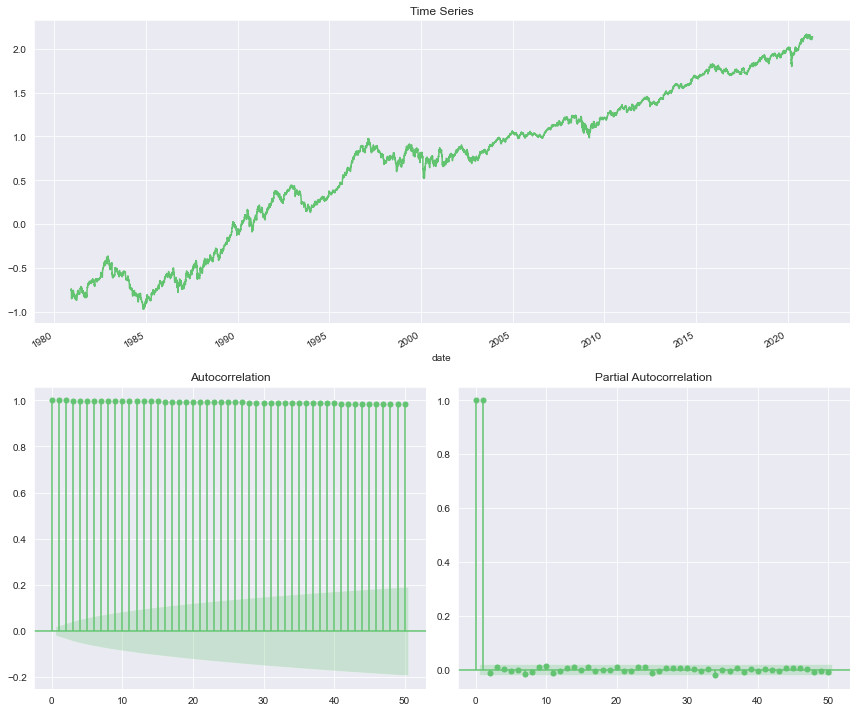

In [15]:
# plot the data with 50 lags
plotds(df_close_log, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(df_close_log)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

### Function for calculating rolling mean and standard deviation 

In [16]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12,min_periods = 1).mean()
    rolling_std = timeseries.rolling(window=12,min_periods = 1).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
 
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


## Subtract Rolling Mean Method

In [17]:
nike_df.close.isnull()

date
1980-12-02    False
1980-12-03    False
1980-12-04    False
1980-12-05    False
1980-12-08    False
              ...  
2021-05-05    False
2021-05-06    False
2021-05-07    False
2021-05-10    False
2021-05-11    False
Name: close, Length: 10197, dtype: bool

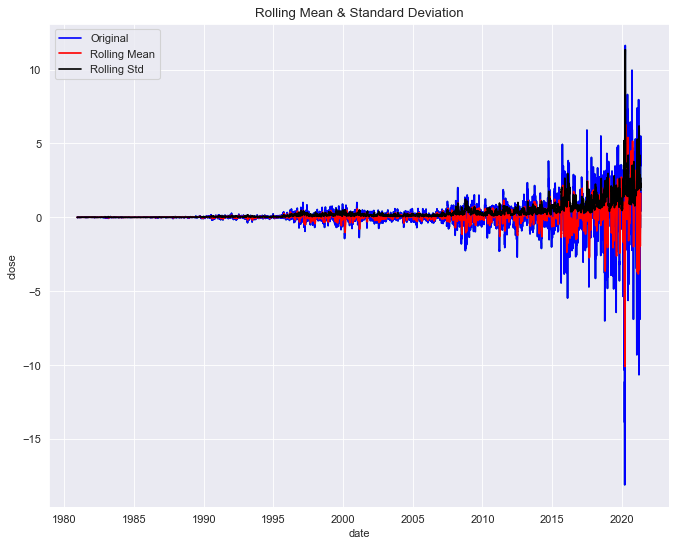

ADF Statistic: -14.451604477779206
p-value: 7.083352760456275e-27
Critical Values:
	1%: -3.4309939847812645
	5%: -2.8618246034501813
	10%: -2.566921489274199


In [18]:
rolling_mean = nike_df.close.rolling(window=12,min_periods = 1).mean()
figure(figsize=(10, 8), dpi=80)

df_minus_mean = nike_df.close - rolling_mean
df_minus_mean.dropna(inplace=True)
sns.lineplot(x=nike_df.index,y=df_minus_mean)
#sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot

get_stationarity(df_minus_mean);


### ACF and PACF plot for Rolling Mean method

ADF Statistic: -14.451604
p-value: 0.000000


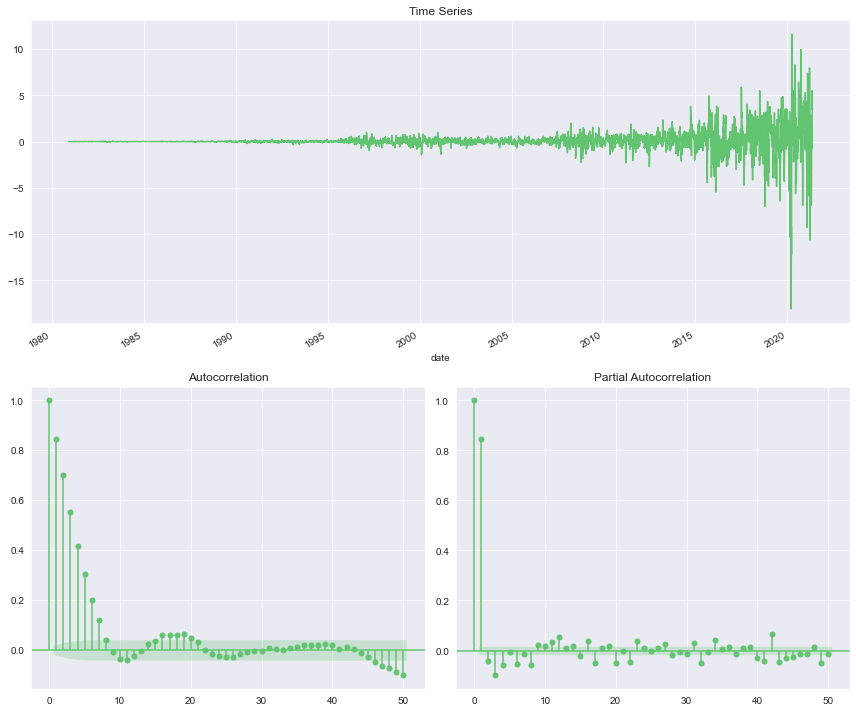

In [19]:
# plot the data with 50 lags
plotds(df_minus_mean, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(df_minus_mean)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

## Exponential Decay Method

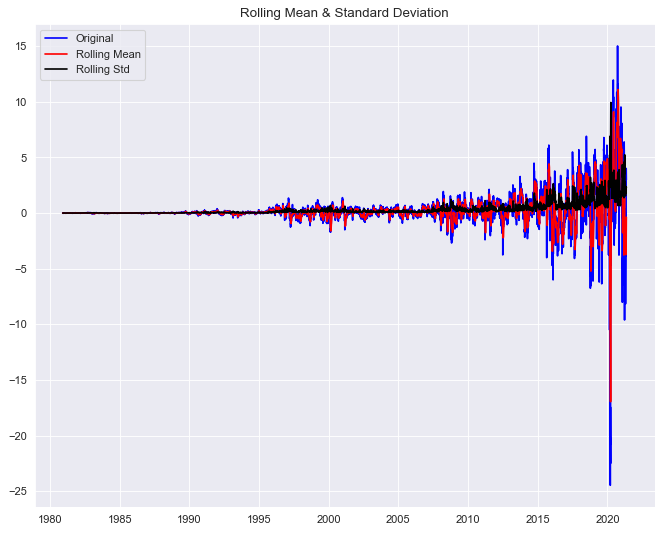

ADF Statistic: -12.281965418151465
p-value: 8.185073242113736e-23
Critical Values:
	1%: -3.4309939847812645
	5%: -2.8618246034501813
	10%: -2.566921489274199


In [20]:
rolling_mean_exp_decay = nike_df.close.ewm(halflife=12, min_periods=0, adjust=True).mean()
figure(figsize=(10, 8), dpi=80)
df_exp_decay = nike_df.close - rolling_mean_exp_decay
df_exp_decay.dropna(inplace=True)
exp_stationary = get_stationarity(df_exp_decay)

### ACF and PACF plot for Exponential Decay method

ADF Statistic: -12.281965
p-value: 0.000000


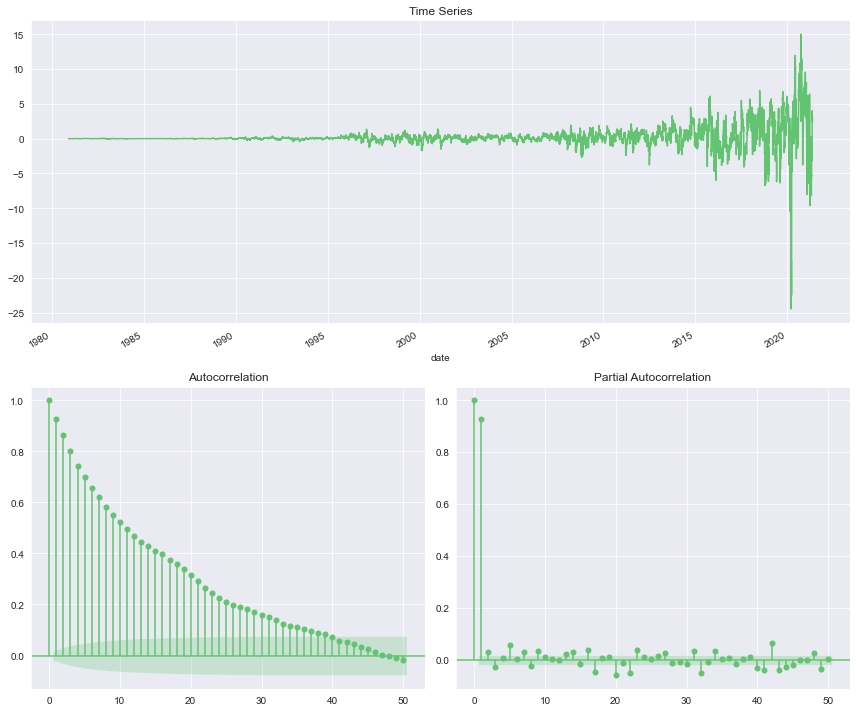

In [21]:
# plot the data with 50 lags
plotds(df_exp_decay, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(df_exp_decay)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

## Time Shift Method

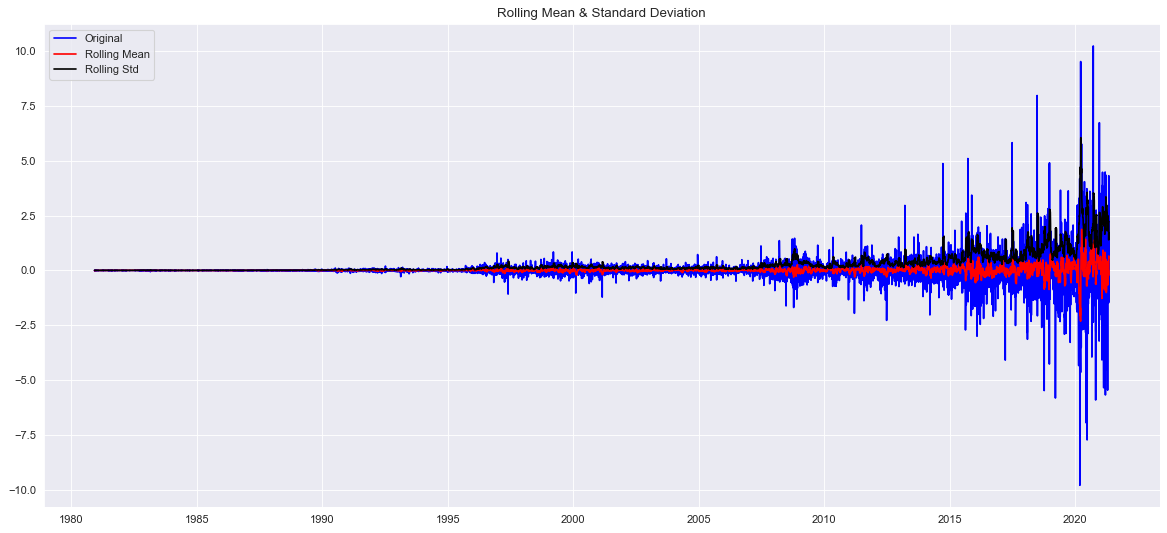

ADF Statistic: -15.257671206957026
p-value: 4.909896484271994e-28
Critical Values:
	1%: -3.4309940482065953
	5%: -2.8618246314774134
	10%: -2.5669215041931146


In [22]:
figure(figsize=(18, 8), dpi=80)

df_shift = nike_df.close - nike_df.close.shift()
df_shift.dropna(inplace=True)
get_stationarity(df_shift)

### ACF and PACF plot for Time Shift method

ADF Statistic: -15.257671
p-value: 0.000000


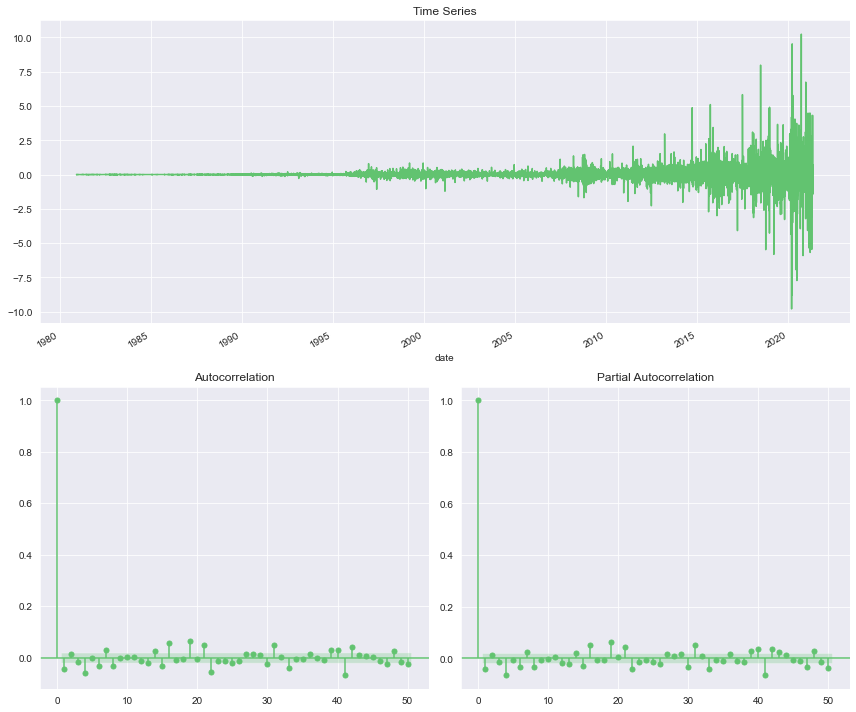

In [23]:
# plot the data with 50 lags
plotds(df_shift, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(df_shift)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

### Import Train Test Split

In [24]:
%store -r XN1_train
%store -r XN1_test

%store -r XN7_train
%store -r XN7_test

%store -r XN30_train
%store -r XN30_test

%store -r XN90_train
%store -r XN90_test


### Set Indicies

In [25]:
XN1_train.set_index(['date'], inplace = True)
XN7_train.set_index(['date'], inplace = True)
XN30_train.set_index(['date'], inplace = True)
XN90_train.set_index(['date'], inplace = True)


### Determine Differencing parameters to Stationarize

In [26]:
model_autoARIMA = auto_arima(XN1_train.close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=2, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25300.907, Time=0.77 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=21993.438, Time=0.90 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.95 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=25298.909, Time=0.28 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=20856.143, Time=1.18 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=20402.576, Time=1.52 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=15.33 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=15.82 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=20400.582, Time=0.80 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=20854.150, Time=0.55 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=4.84 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=3.29 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 55.236 seconds
                               SARIMAX Results                                
Dep. Variable:          

In [27]:
model_autoARIMA = auto_arima(XN7_train.close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=2, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25269.578, Time=1.60 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=21954.228, Time=0.90 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.47 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=25267.578, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=20794.732, Time=1.17 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=20345.322, Time=1.56 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=17.93 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=13.26 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=20343.322, Time=0.82 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=20792.732, Time=0.62 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=5.17 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=3.13 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 55.828 seconds
                               SARIMAX Results                                
Dep. Variable:          

In [28]:
model_autoARIMA = auto_arima(XN30_train.close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=2, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25008.500, Time=0.84 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=21676.282, Time=0.91 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.49 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=25006.500, Time=0.28 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=20548.503, Time=1.14 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=20134.576, Time=1.40 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=20.59 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=11.73 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=20132.576, Time=0.66 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=20546.503, Time=0.53 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=5.22 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=3.77 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 56.558 seconds
                               SARIMAX Results                                
Dep. Variable:          

In [29]:
model_autoARIMA = auto_arima(XN90_train.close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=2, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=24357.710, Time=0.98 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=20872.687, Time=0.90 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.44 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=24355.711, Time=0.28 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=19760.581, Time=1.16 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=19415.389, Time=1.40 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=15.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=14.65 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=19413.389, Time=0.82 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=19758.582, Time=0.62 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=4.07 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=3.81 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 53.256 seconds
                               SARIMAX Results                                
Dep. Variable:          

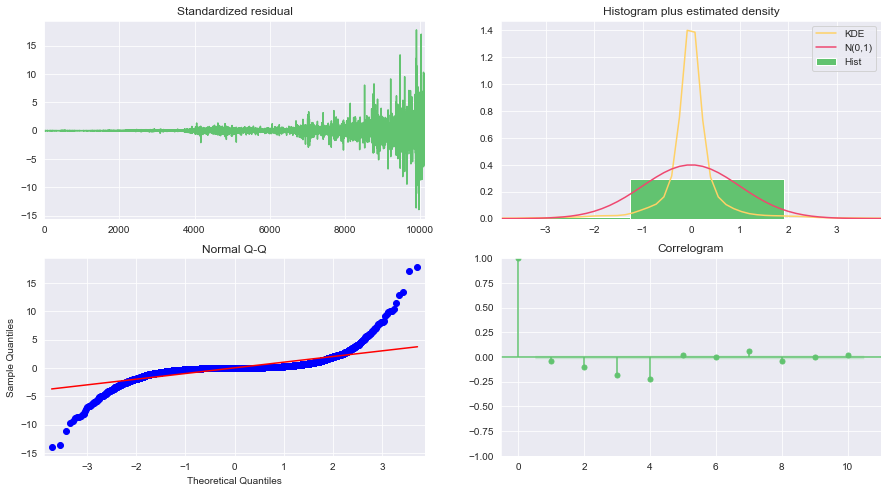

In [30]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

# Fit Models

### Fit 1 Day Model

In [31]:
XN1_train

,open,high,low,close,adj_close,volume,year,month,day,week_of_year,day_of_week,day_of_week_number,close_open_variation,intraday_variation,daily_change,moving_average_10,moving_average_15,moving_average_50
date,,,,,,,,,,,,,,,,,,
1980-12-02,0.179688,0.183594,0.179688,0.179688,0.132428,100710400,1980,12,2,49,Tuesday,2,0.000000,2.173768,0.000000,0.179688,0.179688,0.179688
1980-12-03,0.177734,0.177734,0.175781,0.175781,0.129549,25177600,1980,12,3,49,Wednesday,3,-1.098833,1.111042,-0.021743,0.177735,0.177735,0.177735
1980-12-04,0.181641,0.183594,0.181641,0.181641,0.133868,22694400,1980,12,4,49,Thursday,4,0.000000,1.075198,0.033337,0.179037,0.179037,0.179037
1980-12-05,0.175781,0.175781,0.171875,0.171875,0.126670,7590400,1980,12,5,49,Friday,5,-2.222083,2.272582,-0.053765,0.177246,0.177246,0.177246
1980-12-08,0.164063,0.164063,0.162109,0.162109,0.119473,5414400,1980,12,8,50,Monday,1,-1.191006,1.205362,-0.056820,0.174219,0.174219,0.174219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,133.369995,134.449997,132.589996,133.029999,133.029999,5053000,2021,5,3,18,Monday,1,-0.254927,1.402822,0.003092,130.970999,131.737332,135.011799
2021-05-04,132.229996,132.589996,130.479996,131.550003,131.550003,6129500,2021,5,4,18,Tuesday,2,-0.514250,1.617106,-0.011125,131.414999,131.604666,134.909399
2021-05-05,132.699997,134.220001,132.080002,132.210007,132.210007,4218000,2021,5,5,18,Wednesday,3,-0.369246,1.620229,0.005017,131.646001,131.601334,134.830999


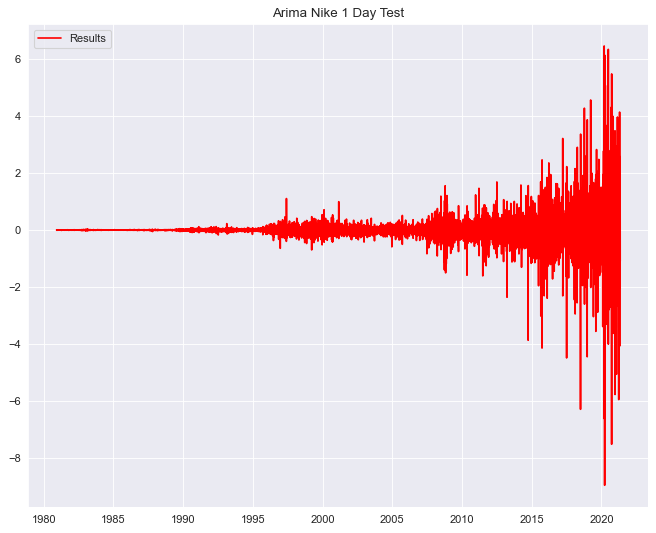

In [32]:
model1 = ARIMA(XN1_train.close, order=(3,2,0)); # Best p,d,q parameters from auto_arima
results1 = model1.fit();
figure(figsize=(10, 8), dpi=80);
plt.plot(results1.fittedvalues, color='red',label='Results');
plt.title('Arima Nike 1 Day Test')
plt.legend()

In [33]:
# Perform Dicky Fuller test
adf_result = adfuller(results1.fittedvalues)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -28.749632
p-value: 0.000000


### Fit 7 Day Model

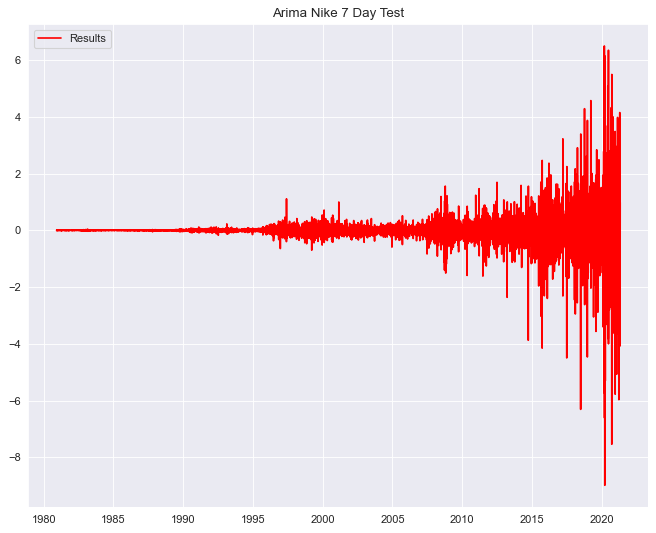

In [34]:
model7 = ARIMA(XN7_train.close, order=(3,2,0)); # Best p,d,q parameters from auto_arima
results7 = model7.fit();
figure(figsize=(10, 8), dpi=80);
plt.plot(results7.fittedvalues, color='red',label='Results');
plt.title('Arima Nike 7 Day Test')
plt.legend()

### Fit 30 Day Model

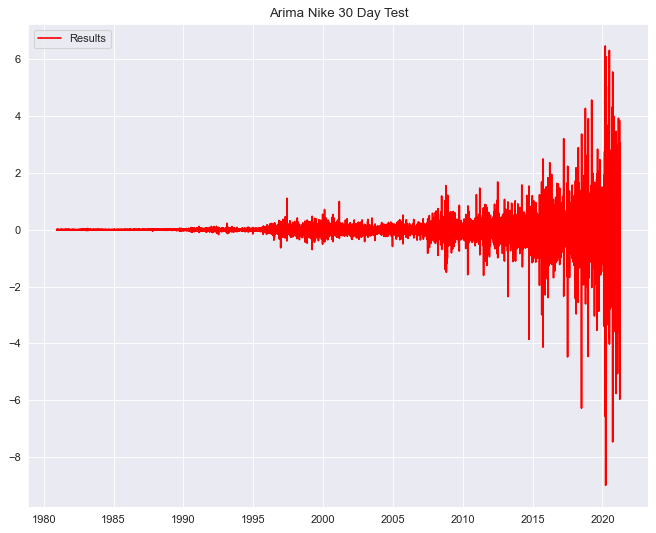

In [35]:
model30 = ARIMA(XN30_train.close, order=(3,2,0)); # Best p,d,q parameters from auto_arima
results30 = model30.fit();
figure(figsize=(10, 8), dpi=80);
plt.plot(results30.fittedvalues, color='red',label='Results');
plt.title('Arima Nike 30 Day Test')
plt.legend()

### Fit 90 Day Model

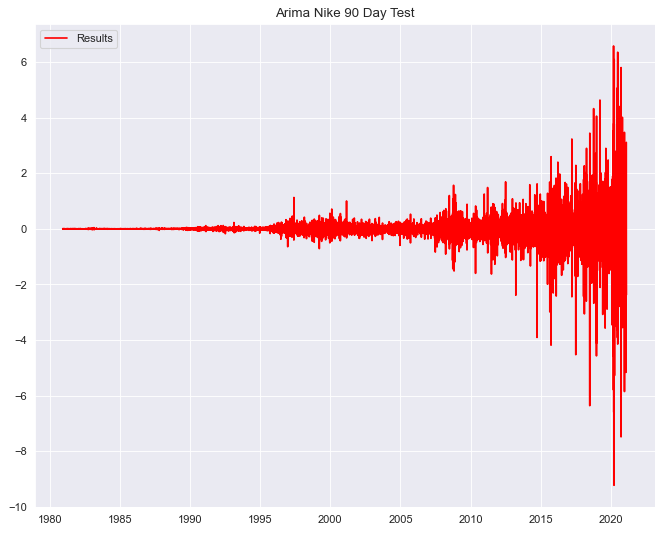

In [36]:
model90 = ARIMA(XN90_train.close, order=(3,2,0)); # Best p,d,q parameters from auto_arima
results90 = model90.fit();
figure(figsize=(10, 8), dpi=80);
plt.plot(results90.fittedvalues, color='red',label='Results');
plt.title('Arima Nike 90 Day Test')
plt.legend()

### Plot Predicted values and Original values based on 1 Day Test data

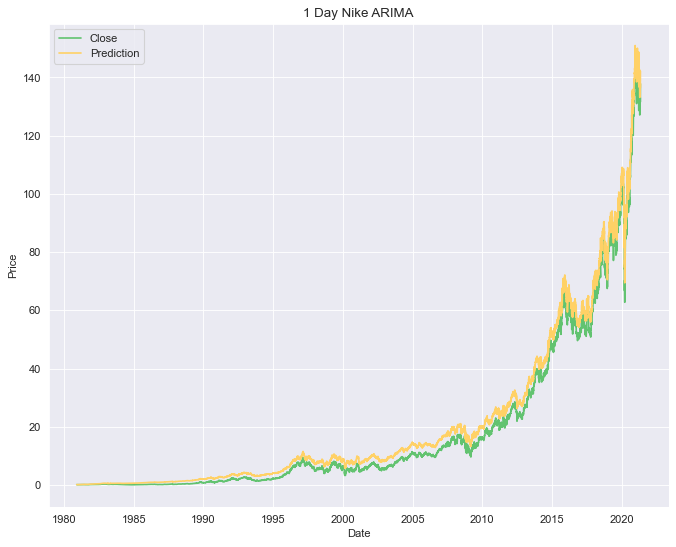

In [37]:
predictions_ARIMA_diff1 = pd.Series(results1.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum1 = predictions_ARIMA_diff1.cumsum()
predictions_ARIMA1 = pd.Series(XN1_train['close'], index=XN1_train.index)
predictions_ARIMA1 = predictions_ARIMA1.add(predictions_ARIMA_diff_cumsum1, fill_value=0)
figure(figsize=(10, 8), dpi=80);
plt.plot(XN1_train['close'], label='Close') 
plt.plot(predictions_ARIMA1,label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('1 Day Nike ARIMA')
plt.legend() 

### 7 Day Train Prediction

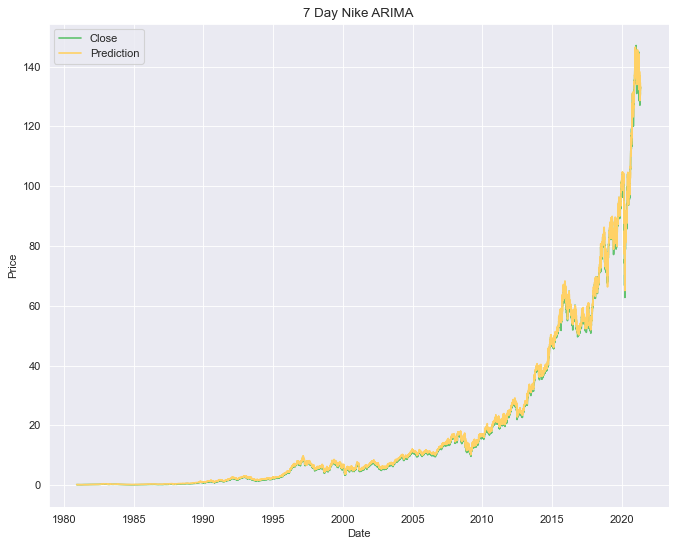

In [38]:
predictions_ARIMA_diff7 = pd.Series(results7.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum7 = predictions_ARIMA_diff7.cumsum()
predictions_ARIMA7 = pd.Series(XN7_train['close'], index=XN7_train.index)
predictions_ARIMA7 = predictions_ARIMA7.add(predictions_ARIMA_diff_cumsum7, fill_value=0)

figure(figsize=(10, 8), dpi=80);
plt.plot(XN7_train['close'], label='Close') 
plt.plot(predictions_ARIMA7,label='Prediction')
plt.title('7 Day Nike ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

### 30 Day Train Prediction

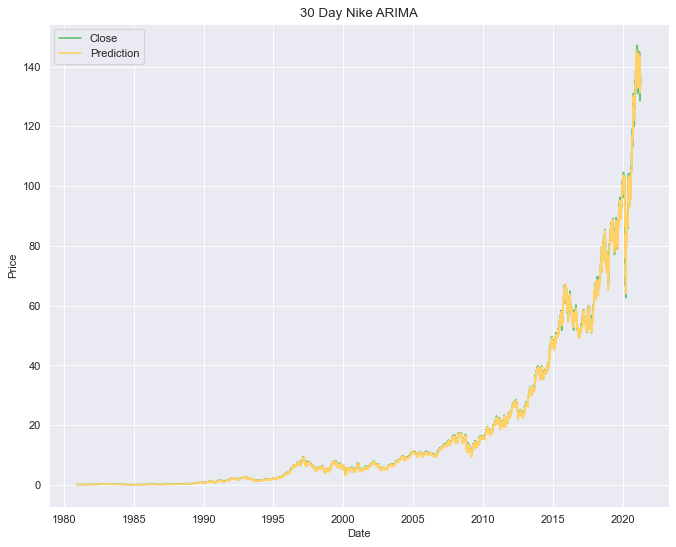

In [39]:
predictions_ARIMA_diff30 = pd.Series(results30.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum30 = predictions_ARIMA_diff30.cumsum()
predictions_ARIMA30 = pd.Series(XN30_train['close'], index=XN30_train.index)
predictions_ARIMA30 = predictions_ARIMA30.add(predictions_ARIMA_diff_cumsum30, fill_value=0)

figure(figsize=(10, 8), dpi=80);
plt.plot(XN30_train['close'], label='Close') 
plt.plot(predictions_ARIMA30,label='Prediction')
plt.title('30 Day Nike ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()    

### 90 Day Train Prediction

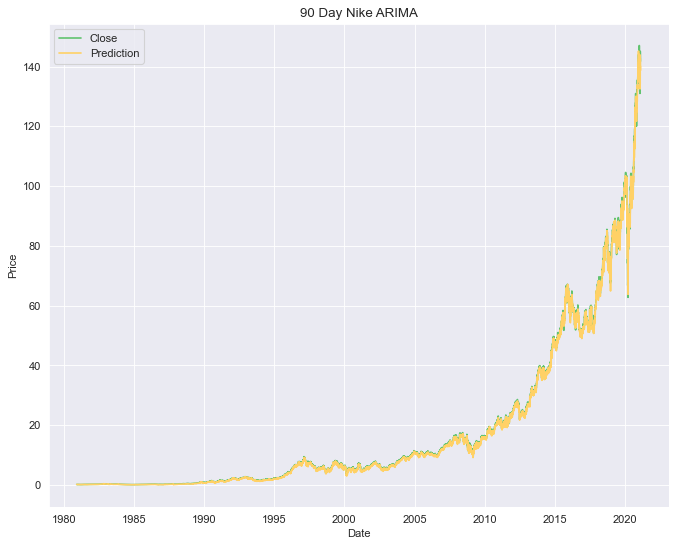

In [40]:
predictions_ARIMA_diff90 = pd.Series(results90.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum90 = predictions_ARIMA_diff90.cumsum()
predictions_ARIMA90 = pd.Series(XN90_train['close'], index=XN90_train.index)
predictions_ARIMA90 = predictions_ARIMA90.add(predictions_ARIMA_diff_cumsum90, fill_value=0)

figure(figsize=(10, 8), dpi=80);
plt.plot(XN90_train['close'], label='Close') 
plt.plot(predictions_ARIMA90,label='Prediction')
plt.title('90 Day Nike ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()    

### 1 Day Forecast

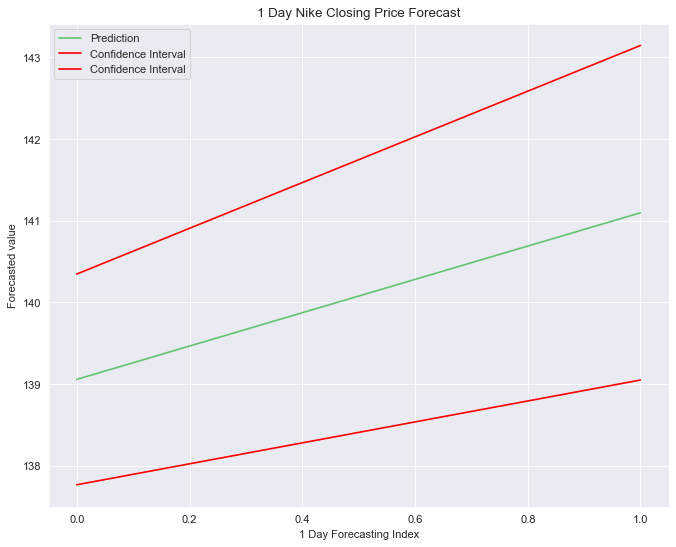

In [41]:
f, err, ci = results1.forecast(2)
figure(figsize=(10, 8), dpi=80);
plt.plot(f,label = 'Prediction');
plt.plot(ci,label='Confidence Interval',color='r');
plt.xlabel('1 Day Forecasting Index');
plt.ylabel('Forecasted value');
plt.title('1 Day Nike Closing Price Forecast');
plt.legend()

# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure


10175    136.639999
10176    133.539993
10177    132.259995
10178    133.669998
10179    134.309998
10180    132.570007
10181    127.110001
10182    129.899994
10183    129.179993
10184    130.190002
10185    131.600006
10186    132.110001
10187    130.710007
10188    133.259995
10189    132.619995
10190    133.029999
10191    131.550003
10192    132.210007
10193    133.490005
10194    137.809998
10195    136.399994
10196    137.119995
Name: close, dtype: float64


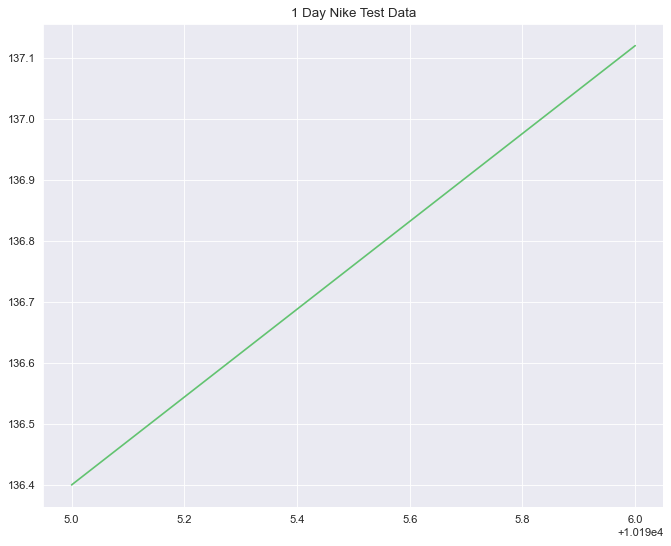

In [42]:
figure(figsize=(10, 8), dpi=80);
plt.plot(XN1_test.close)
plt
plt.title('1 Day Nike Test Data');
print(XN30_test.close)

### 7 Day Forecast

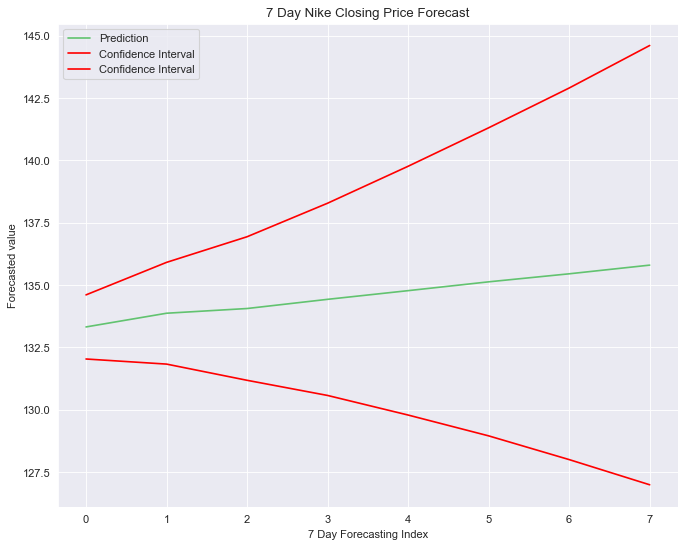

In [43]:
f, err, ci = results7.forecast(8)
figure(figsize=(10, 8), dpi=80);
plt.plot(f,label = 'Prediction');
plt.plot(ci,label='Confidence Interval',color='r');
plt.xlabel('7 Day Forecasting Index');
plt.ylabel('Forecasted value');
plt.title('7 Day Nike Closing Price Forecast');
plt.legend()

# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure


10175    136.639999
10176    133.539993
10177    132.259995
10178    133.669998
10179    134.309998
10180    132.570007
10181    127.110001
10182    129.899994
10183    129.179993
10184    130.190002
10185    131.600006
10186    132.110001
10187    130.710007
10188    133.259995
10189    132.619995
10190    133.029999
10191    131.550003
10192    132.210007
10193    133.490005
10194    137.809998
10195    136.399994
10196    137.119995
Name: close, dtype: float64


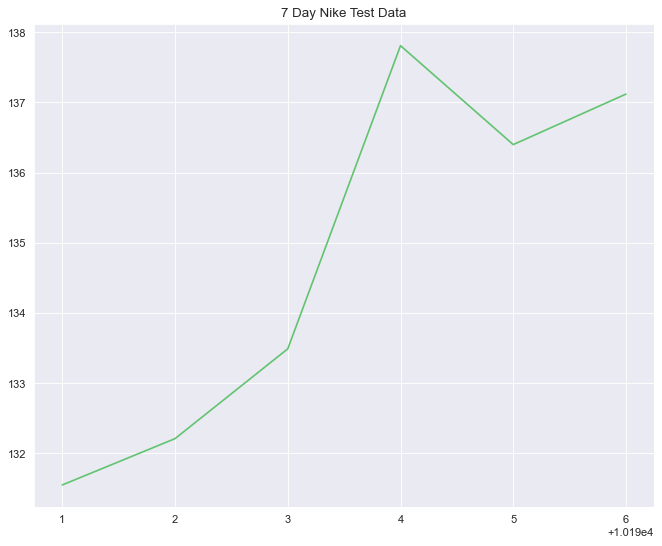

In [44]:
figure(figsize=(10, 8), dpi=80);
plt.plot(XN7_test.close)
plt
plt.title('7 Day Nike Test Data');
print(XN30_test.close)

### 30 Day Forecast

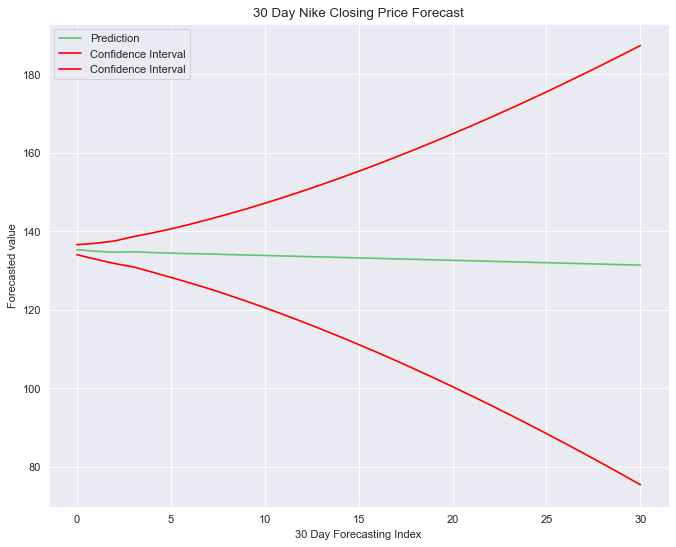

In [45]:
f, err, ci = results30.forecast(31)
figure(figsize=(10, 8), dpi=80);
plt.plot(f,label = 'Prediction');
plt.plot(ci,label='Confidence Interval',color='r');
plt.xlabel('30 Day Forecasting Index');
plt.ylabel('Forecasted value');
plt.title('30 Day Nike Closing Price Forecast');
plt.legend()

# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure


10175    136.639999
10176    133.539993
10177    132.259995
10178    133.669998
10179    134.309998
10180    132.570007
10181    127.110001
10182    129.899994
10183    129.179993
10184    130.190002
10185    131.600006
10186    132.110001
10187    130.710007
10188    133.259995
10189    132.619995
10190    133.029999
10191    131.550003
10192    132.210007
10193    133.490005
10194    137.809998
10195    136.399994
10196    137.119995
Name: close, dtype: float64


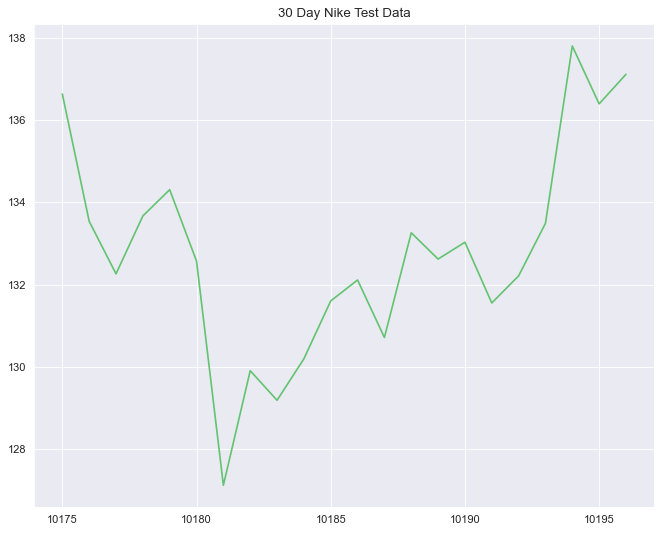

In [46]:
figure(figsize=(10, 8), dpi=80);
plt.plot(XN30_test.close)
plt
plt.title('30 Day Nike Test Data');
print(XN30_test.close)

### 90 Day Forecast

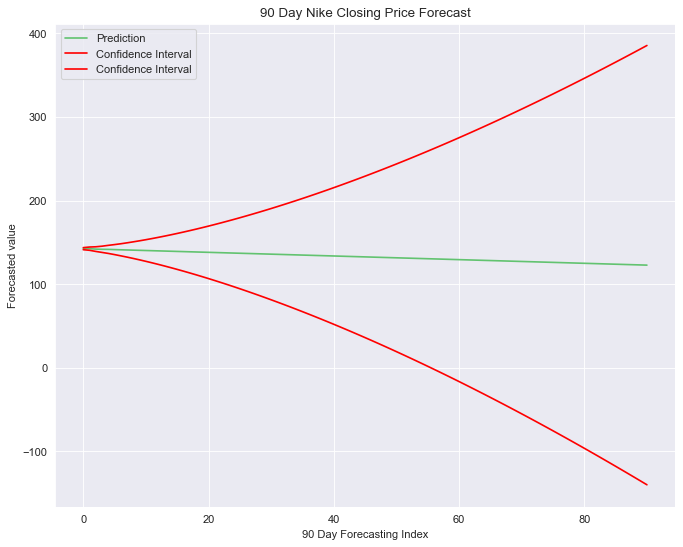

In [47]:
f, err, ci = results90.forecast(91)
figure(figsize=(10, 8), dpi=80);
plt.plot(f,label = 'Prediction');
plt.plot(ci,label='Confidence Interval',color='r');
plt.xlabel('90 Day Forecasting Index');
plt.ylabel('Forecasted value');
plt.title('90 Day Nike Closing Price Forecast');
plt.legend()

# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure


10134    142.460007
10135    143.539993
10136    142.119995
10137    141.710007
10138    143.990005
            ...    
10192    132.210007
10193    133.490005
10194    137.809998
10195    136.399994
10196    137.119995
Name: close, Length: 63, dtype: float64


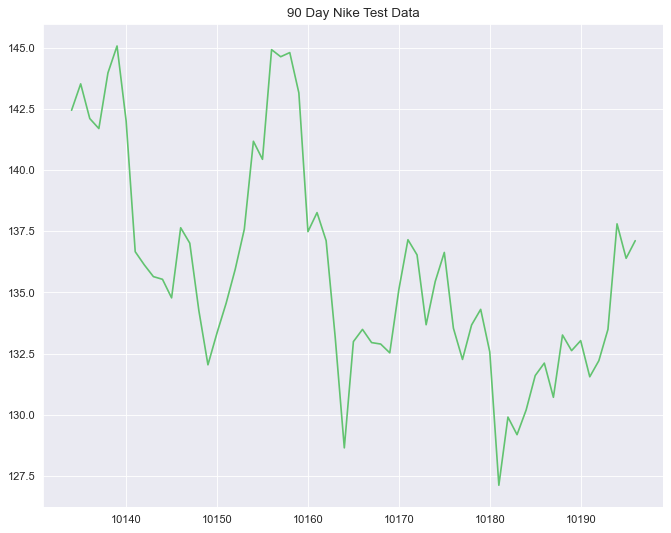

In [48]:
figure(figsize=(10, 8), dpi=80);
plt.plot(XN90_test.close)
plt
plt.title('90 Day Nike Test Data')
print(XN90_test.close)

## Evaluation

### Calculations to determine accuracy of the ARIMA model predictions

In [49]:
mse = mean_squared_error(XN1_train.close, predictions_ARIMA1)
print('1 day test data MSE: '+str(mse))

mae = mean_absolute_error (XN1_train.close,predictions_ARIMA1)
print('1 day test data MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(XN1_train.close,predictions_ARIMA1))
print('1 day test data RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions_ARIMA1 -  XN1_train.close)/np.abs(XN1_train.close))
print('1 day test data MAPE: '+str(mape))


MSE: 9.482922770216607
MAE: 2.63484818676012
RMSE: 3.0794354629081946
MAPE: 0.7746569367062774


In [50]:
mse = mean_squared_error(XN7_train.close, predictions_ARIMA7)
print('7 day test data MSE: '+str(mse))
mae = mean_absolute_error (XN7_train.close,predictions_ARIMA7)
print('7 day test data MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(XN7_train.close,predictions_ARIMA7))
print('7 day test data RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions_ARIMA7 -  XN7_train.close)/np.abs(XN7_train.close))
print('7 day test data MAPE: '+str(mape))


MSE: 0.4825848343768059
MAE: 0.4559510961091874
RMSE: 0.6946832619091998
MAPE: 0.12057135021192596


In [51]:
mse = mean_squared_error(XN30_train.close, predictions_ARIMA30)
print('30 day test data MSE: '+str(mse))

mae = mean_absolute_error (XN30_train.close,predictions_ARIMA30)
print('30 day test data MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(XN30_train.close,predictions_ARIMA30))
print('30 day test data RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions_ARIMA30 -  XN30_train.close)/np.abs(XN30_train.close))
print('30 day test data MAPE: '+str(mape))


MSE: 0.3068434357803927
MAE: 0.26917301601469446
RMSE: 0.5539345049555883
MAPE: 0.04965958035867481


In [52]:
mse = mean_squared_error(XN90_train.close, predictions_ARIMA90)
print('90 day test data MSE: '+str(mse))

mae = mean_absolute_error (XN90_train.close,predictions_ARIMA90)
print('90 day test data MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(XN90_train.close,predictions_ARIMA90))
print('90 day test data RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions_ARIMA90 -  XN90_train.close)/np.abs(XN90_train.close))
print('90 day test data MAPE: '+str(mape))


MSE: 0.3571082516587006
MAE: 0.348322838423354
RMSE: 0.5975853509405168
MAPE: 0.08221599771134988
